## XI.9.2 b:
$ y'' + \frac{0.5}{1-0.5y}y'^2 = 0 $

$ y(0) = y_0 $, $ y(1) = 0 $

Denote:

$ y = v(t) $, $ y' = u(t) $

Thus:

$ u'(t) = \frac{0.5}{1-0.5v}u^2 $ \
$ v'(t) = u $

$ v(0) = y_0 $, $ v(1) = 0 $


In [199]:
import matplotlib.pyplot as plt
import numpy as np

# Vector norm
def norm_1(vec) :
    return np.amax(abs(vec))

# Newton non-linear system solver
def solve_Newton(func, J, x0, epsilon, extra_arg) :
    N = len(x0)
    x = x0
    x_prev = x0
    func_value = func(x0, *extra_arg)
    
    while norm_1(func_value) >= epsilon :
        x_prev = x
        J_value = J(x, *extra_arg)
        func_value = func(x, *extra_arg)

        inv_J_value = np.linalg.inv(J_value)
        x = x_prev - inv_J_value.dot(func_value)
    
    return x


# Can use lib function instead:
# from scipy import optimize
# optimize.fsolve


In [239]:
# Constant parameters
T_END = 1
H_STEP = 0.00005

# Use Gauss method of the 4th order of accuracy
# Butcher matrix:
# c | A
# -----
#   | b
c = np.array([1/2 - np.sqrt(3)/6, 1/2 + np.sqrt(3)/6])
b = np.array([1/2, 1/2])

A = np.array([[1/4, 1/4-np.sqrt(3)/6],
              [1/4-np.sqrt(3)/6, 1/4]])


In [240]:
# y = [u, v]
def func(y) :
    return np.array([-y[0]*y[0] / (2-y[1]), y[0]])

def func_J(y) :
    return np.array([[-2*y[0] / (2-y[1]), -y[0]*y[0] / ((2-y[1]) * (2-y[1]))],
                     [1, 0]])

def k_func(k, *extra_arg) :
    f = extra_arg[0]
    f_J = extra_arg[1]
    h = extra_arg[2]
    y_prev = extra_arg[3]
    
    k1 = k[:2]
    k2 = k[2:]
    
    f1 = f(y_prev + h*(A[0][0]*k1 + A[0][1]*k2))
    f2 = f(y_prev + h*(A[1][0]*k1 + A[1][1]*k2))

    return np.append(f1-k1, f2-k2)

def k_func_J(k, *extra_arg) :
    f = extra_arg[0]
    f_J = extra_arg[1]
    h = extra_arg[2]
    y_prev = extra_arg[3]

    J_res = np.zeros([0, 4])
    
    for i in [0, 1] :
        f_J_val = f_J(y_prev + h*(A[i][0]*k[:2] + A[i][1]*k[2:]))

        for j in range(0, 2) :
            J_1 = f_J_val[j]*A[i][0]
            J_2 = f_J_val[j]*A[i][1]
            J_add = np.array([np.concatenate((J_1, J_2))])
            J_res = np.concatenate((J_res, J_add), axis=0)

    return h * J_res - np.eye(4)

def runge_kutta_iteration(f, f_J, y_prev, h_step) :
    k0 = np.ones(4)
    newton_epsilon = 0.001
    k = solve_Newton(k_func, k_func_J, k0, newton_epsilon, (f, f_J, h_step, y_prev))
#     k = optimize.fsolve(k_func, k0, (f, f_J, h_step, y_prev))

    k = np.array_split(k, 2)
    return y_prev + h_step*(b[0]*k[0] + b[1]*k[1])

def solve_runge_kutta(y0, h_step) :
    Y = np.zeros([int(T_END / h_step), 2])
    Y[0] = y0

    try:
        for i in range(1, np.shape(Y)[0]) :
            Y[i] = runge_kutta_iteration(func, func_J, Y[i-1], h_step)

    except np.linalg.LinAlgError:
        print("ERROR: Singular matrix in Runge-Kutta iteration")
    
    return Y


In [241]:
def param_func(y_p_deriv) :
    global param_func_y
    J = func_J(param_func_y)
    return np.array([J[0][0]*y_p_deriv[0] + J[0][1]*y_p_deriv[1], y_p_deriv[0]])

def param_func_J(y_p_deriv) :
    global param_func_y
    return func_J(param_func_y)

param_func_y = 0

def solve_param_runge_kutta(h_step, Y) :
    global param_func_y
    
    param_Y = np.zeros([int(T_END / h_step), 2])
    param_Y[0] = [0, 1]

    try:
        for i in range(1, np.shape(Y)[0]) :
            param_func_y = Y[i]
            param_Y[i] = runge_kutta_iteration(param_func, param_func_J, param_Y[i-1], h_step)

    except np.linalg.LinAlgError:
        print("ERROR: Singular matrix in Runge-Kutta iteration")
    
    return param_Y

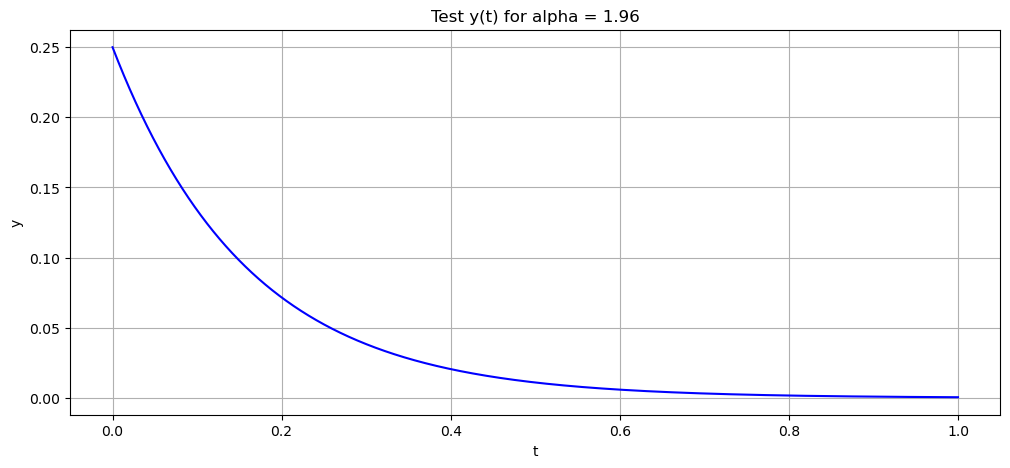

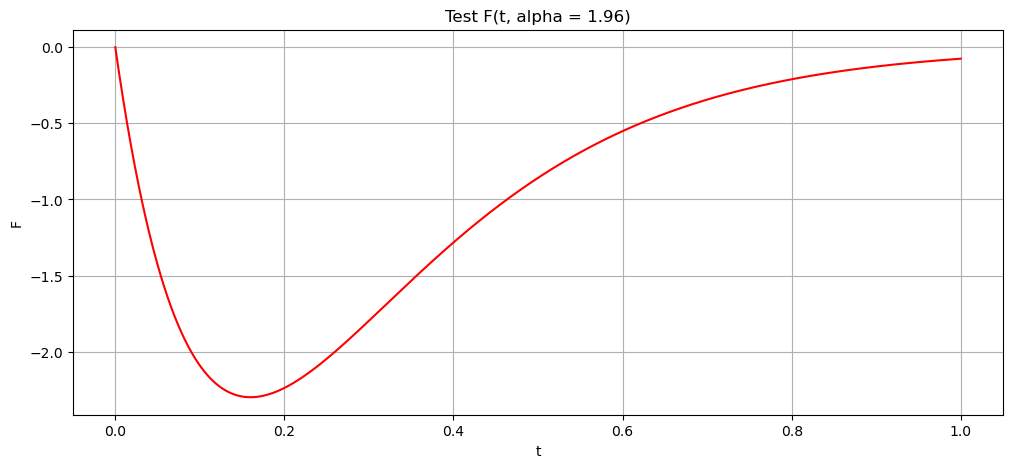

In [242]:
# Test Runge-Kutta solution for some alpha

import matplotlib.pyplot as plt

t = np.arange(start=0, stop=T_END, step=H_STEP)
test_alpha = 1.96
test_sol = solve_runge_kutta([0.25, test_alpha], H_STEP)
test_param = solve_param_runge_kutta(H_STEP, test_sol)

plt.figure(figsize=[12, 5], dpi=100)
plt.plot(t, test_sol[:, 0],'b')
plt.xlabel("t")
plt.ylabel("y")
plt.title("Test y(t) for alpha = %s" % test_alpha)
plt.grid()

plt.show()

plt.figure(figsize=[12, 5], dpi=100)
plt.plot(t, test_param[:, 0],'r')
plt.xlabel("t")
plt.ylabel("F")
plt.title("Test F(t, alpha = %s)" % test_alpha)
plt.grid()

plt.show()

In [249]:
# Calculate alpha with Newton method
def solve_param_Newton(y_0, alpha_0, h_step, epsilon) :
    alpha = alpha_0
    
    f = epsilon * 2
    f_arr = np.zeros(int(T_END / h_step))

    while abs(f) > epsilon :
        f_arr = solve_runge_kutta([y_0, alpha], h_step)
        f_deriv_arr = solve_param_runge_kutta(h_step, f_arr)

        f = f_arr[-1][0]
        f_deriv = f_deriv_arr[-1][0]

        alpha = alpha - f / f_deriv
        
    return (alpha, f_arr)

alpha =  1.9709171123205402
border error =  0.00014659914805895737


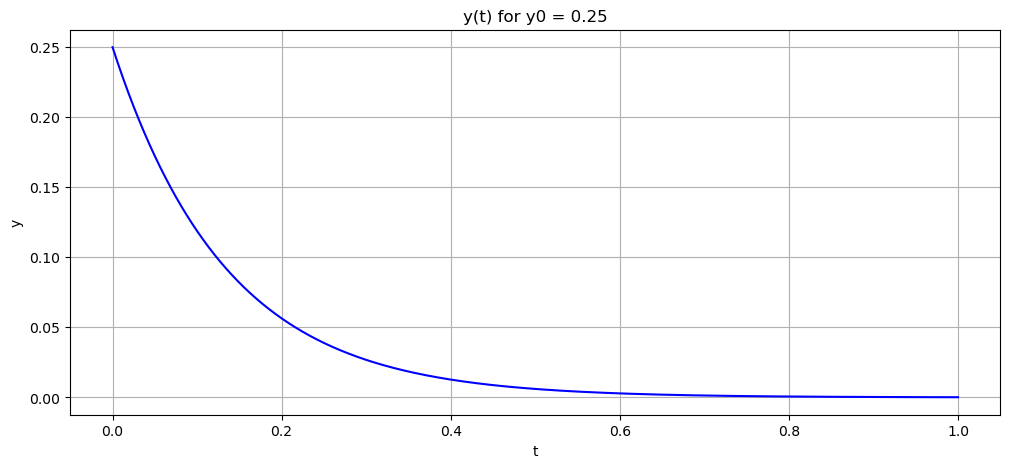

alpha =  1.9361382274606465
border error =  0.0006450687754233336


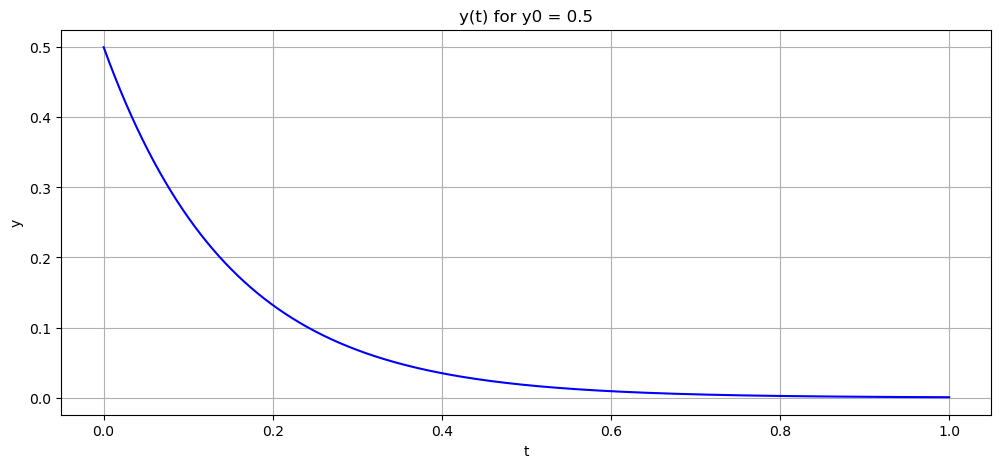

alpha =  1.8807636856620271
border error =  0.0007269126713256664


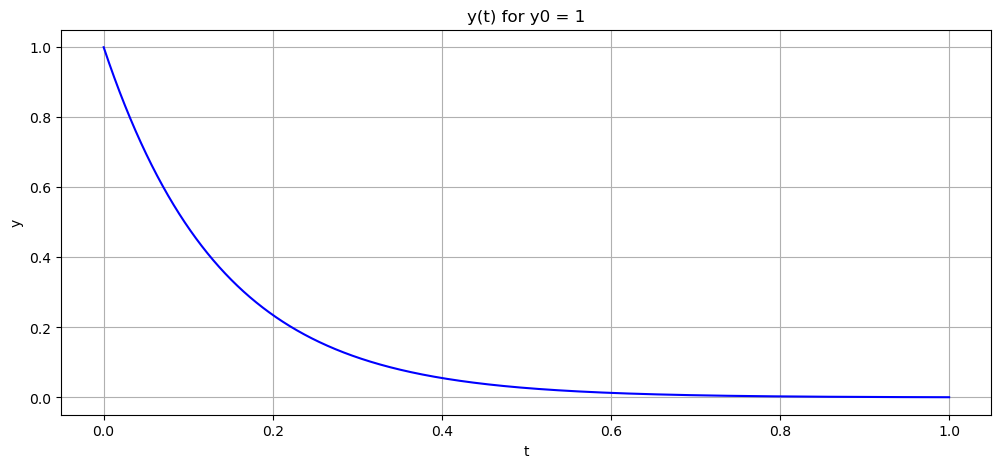

alpha =  1.8411366258139832
border error =  0.00037053892068625684


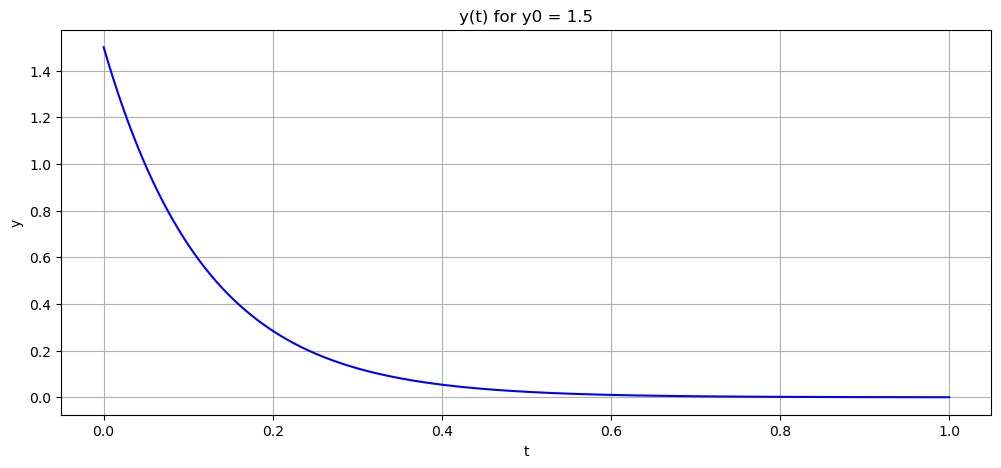

alpha =  1.8144951618311522
border error =  0.0003407798181690188


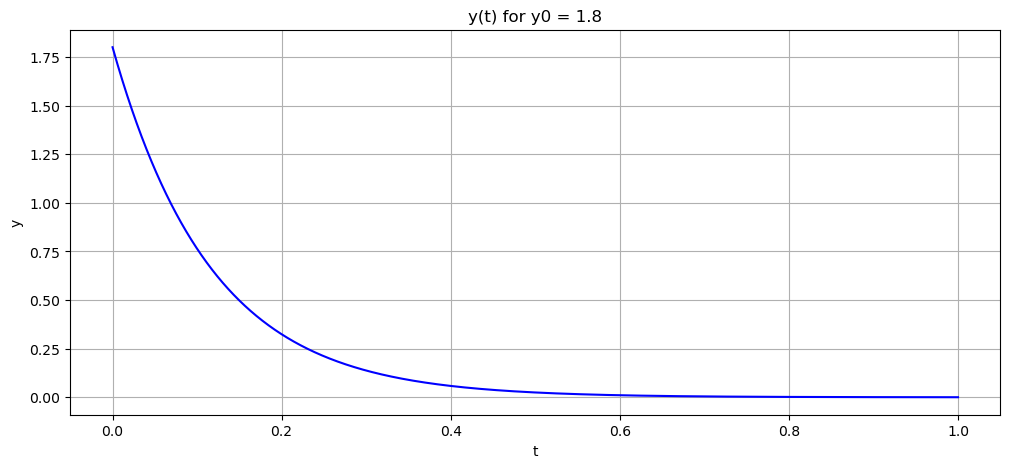

alpha =  1.8132056236334007
border error =  0.00022341164004682196


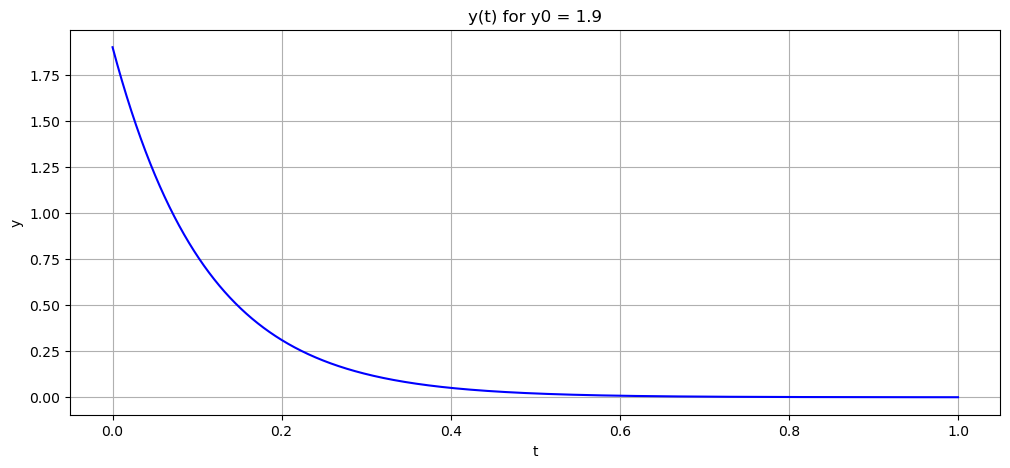

alpha =  1.8126104521486663
border error =  0.00018070125013367895


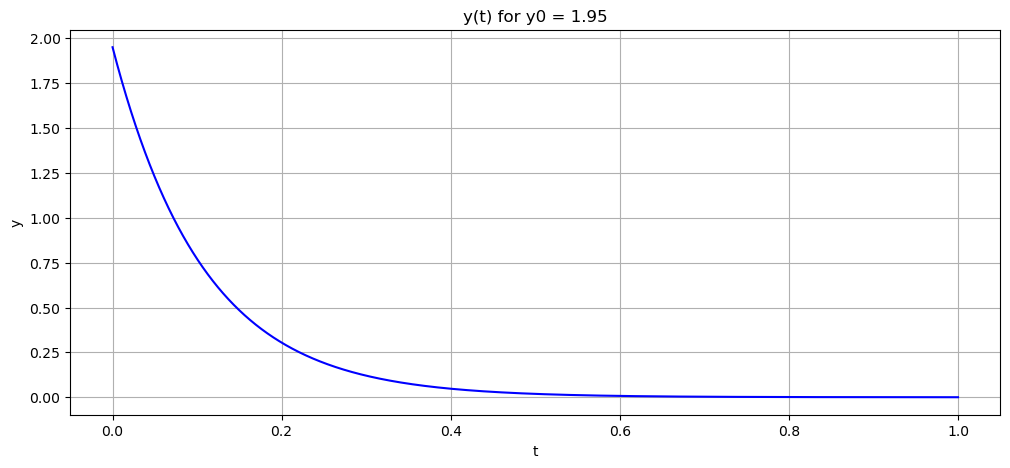

In [250]:

t = np.arange(start=0, stop=T_END, step=H_STEP)

for y0 in [0.25, 0.5, 1, 1.5, 1.8, 1.9, 1.95] :
    alpha, sol = solve_param_Newton(y0, 1.79, H_STEP, 0.001) # 1.79
    print("alpha = ", alpha)
    print("border error = ", abs(sol[-1][0]))
    
    plt.figure(figsize=[12, 5], dpi=100)
    plt.plot(t, sol[:, 0],'b')
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title("y(t) for y0 = %s" % y0)
    plt.grid()

    plt.show()
